# Modeling technical noise - example notebook
August George, PNNL, 2024

## imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyro

import nocap.process as process

## generate example data 
using stratified uniform distributions (each gene/column has it's own uniform distribution)

In [2]:
num_genes = 200
num_cells = 100
np.random.seed(42)

clean_expression_data = process.generate_test_data_tensor(
    n_rows=num_cells, n_cols=num_genes, scale_dist_params=(1, 3)
)

gene_names = [f"gene{i+1}" for i in range(num_genes)]
sample_indices = [f"cell{i+1}" for i in range(num_cells)]
clean_expression_df = pd.DataFrame(clean_expression_data, columns=gene_names, index=sample_indices)

clean_expression_df.head()

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene191,gene192,gene193,gene194,gene195,gene196,gene197,gene198,gene199,gene200
cell1,446.294586,36.149208,22.515673,0.039011,2.168313,0.044286,1.959581,0.026539,0.298586,332.177063,...,0.345934,6.409266,0.577986,0.072705,0.042297,0.056482,7.815240,3.968296,1.349174,0.415433
cell2,392.087219,34.466408,36.650356,0.035658,14.150066,0.050805,1.524664,0.040337,0.120930,207.298492,...,0.364070,3.761487,4.145340,0.093800,0.043970,0.046046,2.128386,15.842263,2.120449,1.578243
cell3,85.847931,136.936066,9.662214,0.036061,4.521170,0.049633,1.290685,0.034517,0.144527,343.995453,...,0.206181,5.151886,1.499152,0.262352,0.044945,0.051271,4.887205,8.118134,6.875115,1.162554
cell4,785.656494,102.021622,19.569271,0.035392,10.041205,0.093600,1.634031,0.037651,0.290000,94.147888,...,0.437360,3.940284,3.198212,0.148195,0.042742,0.057073,8.590379,8.609227,2.398813,1.330149
cell5,447.471222,144.911743,24.094328,0.036986,8.276869,0.074413,0.467297,0.028857,0.273936,316.699066,...,0.195637,5.030766,5.012934,0.257775,0.043857,0.060221,7.664897,9.906755,5.269523,0.950932


## apply noise processes
using methods motivated by SERGIO (doi:[10.1016/j.cels.2020.08.003](https://doi.org/10.1016/j.cels.2020.08.003)):
1. biological noise --> log normal process
2. outliers --> Bernoulli + log normal process
3. library size effects --> row normalization and log normal scaling process
4. dropout effects --> quantile-based logicistic dropout process
5. UMI count effects --> Poisson process


In [3]:
data_w_bio_noise = process.apply_lognormal_noise_process(clean_expression_data)
umi_counts = process.apply_poisson_process(data_w_bio_noise)
outlier_data = process.apply_bernoulli_lognormal_outlier_process(umi_counts)
library_size_data = process.apply_row_normalization_and_lognormal_scaling_process(outlier_data)
dropout_data = process.apply_quantile_logistic_dropout_process(library_size_data)

## visualization
showing the log10 change in expression levels after applying the noise processes

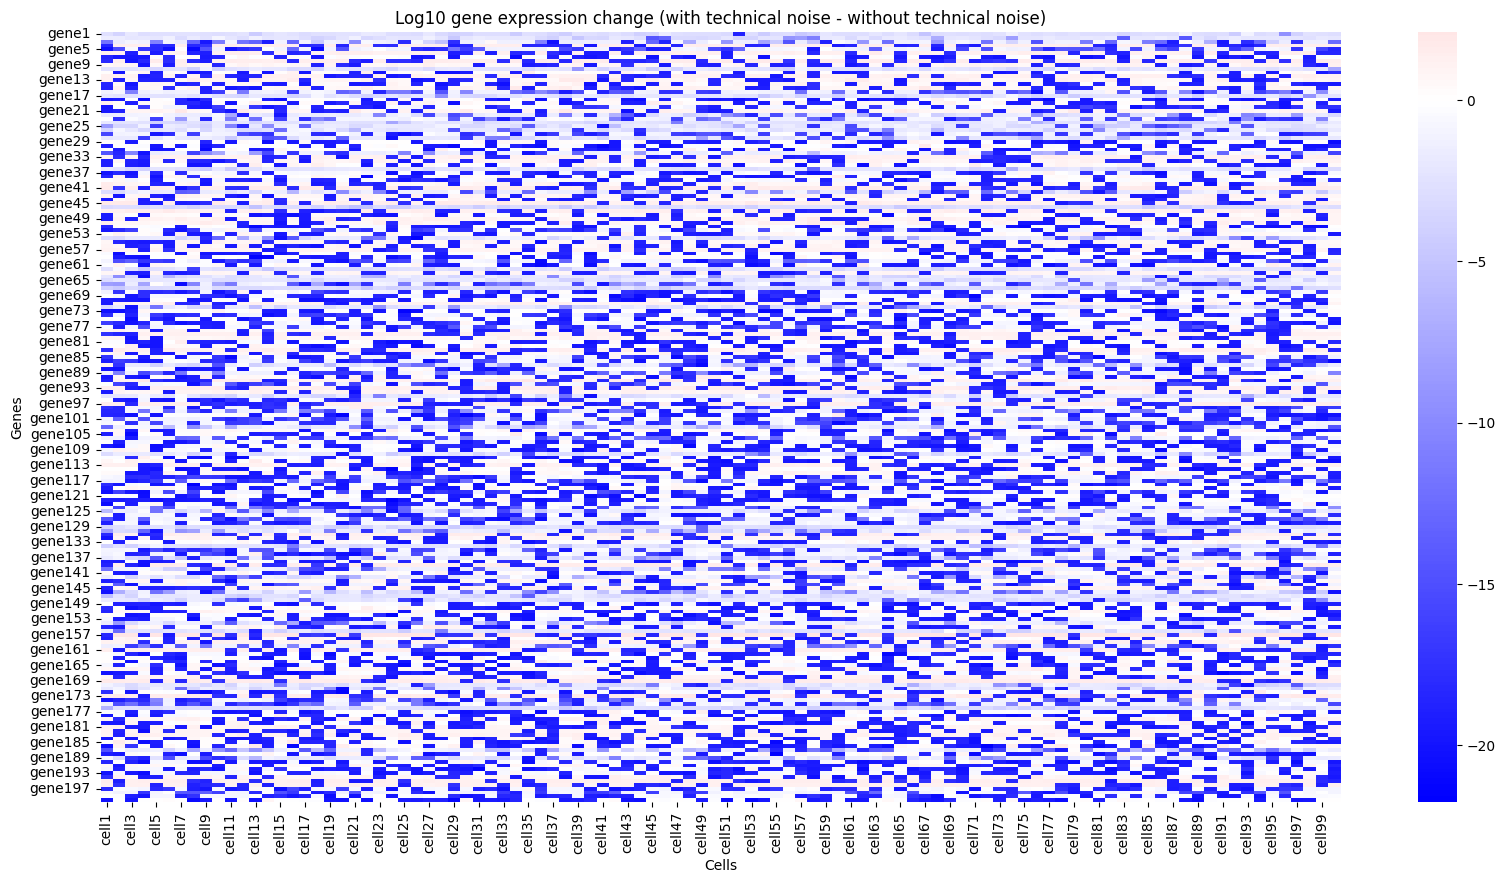

In [4]:
df1 = clean_expression_df
df2 = pd.DataFrame(dropout_data, columns=gene_names, index=sample_indices)
title = "Log10 gene expression change (with technical noise - without technical noise)"

df1_safe = df1.replace(0, 1)
df2_safe = df2.replace(0, 1)
log10_change = np.log10(df2_safe / df1_safe)

plt.figure(figsize=(20, 10))
sns.heatmap(log10_change.T, cmap="bwr", center=0, cbar=True)
plt.title(title)
plt.xlabel("Cells")
plt.ylabel("Genes")
plt.show()

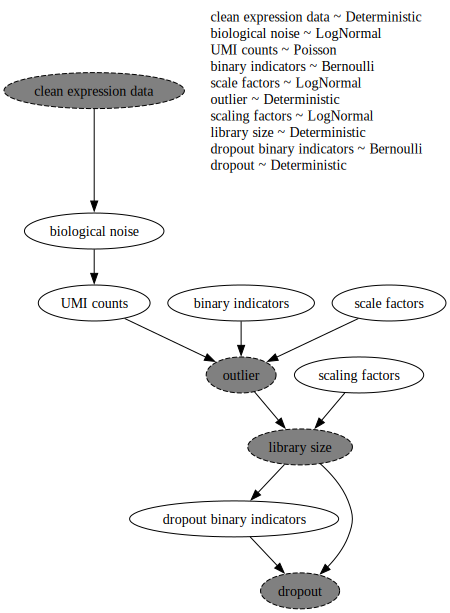

In [8]:
import torch
import inspect
import pyro
import os
os.environ["PATH"] += os.pathsep + "/opt//bin"

def model(data):
    clean_expression_data = pyro.deterministic("clean expression data", data)
    data_w_bio_noise = process.apply_lognormal_noise_process(clean_expression_data)
    umi_counts = process.apply_poisson_process(data_w_bio_noise)
    outlier_data = process.apply_bernoulli_lognormal_outlier_process(umi_counts)
    library_size_data = process.apply_row_normalization_and_lognormal_scaling_process(outlier_data)
    dropout_data = process.apply_quantile_logistic_dropout_process(library_size_data)
    return dropout_data
pyro.render_model(model, model_args=(clean_expression_data,), render_deterministic=True, render_distributions=True, filename="technical_noise.png")



In [9]:
import os
import math
import numpy as np
import scipy.sparse
import pandas as pd
import scanpy as sc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
from pyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule
import pyro.distributions as dist
from IPython.display import Image
import torch

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

sns.set_style("white")

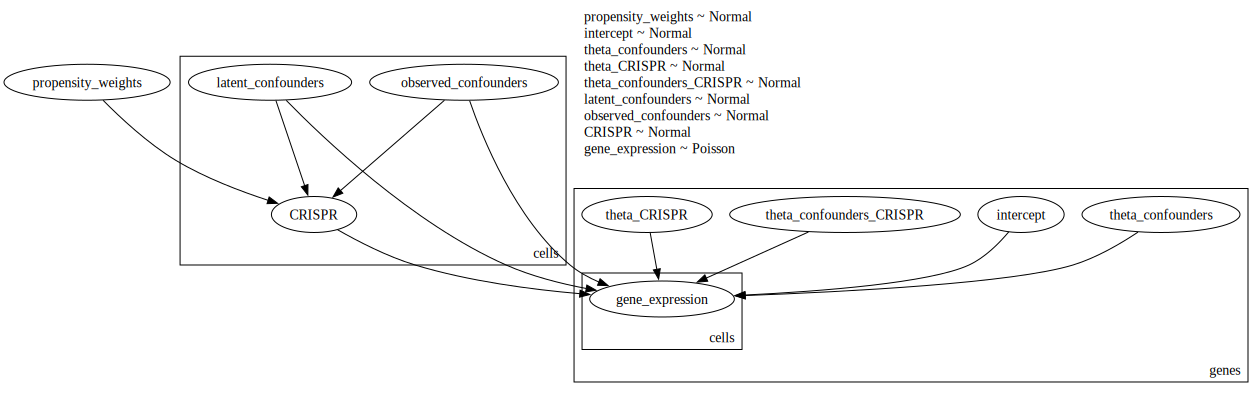

In [15]:
class CRISPRPerturbationModel(PyroModule):
    def __init__(self, num_cells: int, num_genes: int, num_observed_confounders: int, num_latent_confounders: int = 3):
        super().__init__()
        self.num_cells = num_cells
        self.num_genes = num_genes
        self.num_observed_confounders = num_observed_confounders
        self.num_latent_confounders = num_latent_confounders
        self.num_confounders = num_observed_confounders + num_latent_confounders
        self.cell_plate = pyro.plate("cells", self.num_cells, dim=-2)
        self.gene_plate = pyro.plate("genes", self.num_genes, dim=-1)

    def forward(self, mask: bool = False):
        prior_scale = 1 / math.sqrt(self.num_confounders)
        propensity_weights = pyro.sample("propensity_weights", dist.Normal(0, prior_scale).expand((self.num_confounders, )).to_event(1))

        # Sample regression weights for each gene
        with self.gene_plate:
            intercept = pyro.sample("intercept", dist.Normal(0, 1))
            theta_confounders = pyro.sample("theta_confounders", dist.Normal(0, prior_scale).expand((self.num_confounders,)).to_event(1)) # G x F
            theta_CRISPR = pyro.sample("theta_CRISPR", dist.Normal(0, 1))
            theta_confounders_CRISPR = pyro.sample("theta_confounders_CRISPR", dist.Normal(0, prior_scale).expand((self.num_confounders,)).to_event(1)) # G x F

        # Compute likelihood
        with self.cell_plate:
            # Sample treatment and confounders (remove from log_prob since we'll always conditioned on them when mask = False)
            latent_confounders = pyro.sample("latent_confounders", dist.Normal(0, 1).expand((self.num_latent_confounders,)).to_event(1))
            observed_confounders = pyro.sample("observed_confounders", dist.Normal(0, 1).expand((self.num_observed_confounders,)).mask(mask).to_event(1))
            observed_confounders = observed_confounders.expand(latent_confounders.shape[:-1] + observed_confounders.shape[-1:])
            confounders = torch.cat([observed_confounders, latent_confounders], dim=-1)  # torch.cat doesn't broadcast

            treatment_mean = torch.einsum("...ngp,...p->...ng", confounders, propensity_weights)
            T = torch.relu(pyro.sample("CRISPR", dist.Normal(treatment_mean, 1)))
            with self.gene_plate:
                # Confounding effects
                confounder_variation = intercept + torch.einsum("...ngp,...gp->...ng", confounders, theta_confounders) # N x G

                # CRISPR dose treatment effects
                treatment_variation = theta_CRISPR * T + torch.einsum("...ngp,...ng,...gp->...ng", confounders, T, theta_confounders_CRISPR) # N x G
                mean = confounder_variation + treatment_variation # N x G
                expressions = pyro.sample("gene_expression", dist.Poisson(rate=torch.exp(mean)))
        return expressions

pyro.render_model(CRISPRPerturbationModel(10, 10, 10, 3), render_distributions=True, render_params=True, filename="CRISPRPerturbationModel.png")

In [16]:
class CRISPRPerturbationATE(pyro.nn.PyroModule):
    def __init__(self, model: CRISPRPerturbationModel, X_pop: torch.tensor):
        super().__init__()
        self.model = model
        # sample population confounders to average over
        self.X_pop = X_pop

    def forward(self, dose_levels: tuple):
        dose_levels = (torch.tensor(0.),) + tuple(torch.as_tensor(dose_level) for dose_level in dose_levels)

        with MultiWorldCounterfactual(), do(actions={"crispr": dose_levels}), \
                condition(data=dict(observed_confounders=self.X_pop[:, None, :])):
            expressions = self.model()
            expressions_dose = gather(expressions, IndexSet(crispr=set(range(2, len(dose_levels) + 1)))) # expressions predicted by model at doses > 0
            expressions_vehicle = gather(expressions, IndexSet(crispr={1})) # expressions predicted by model at dose 0 (vehicle)
            return pyro.deterministic("ATEs", (expressions_dose - expressions_vehicle).mean(dim=-2))

ate_model = CRISPRPerturbationATE(
    CRISPRPerturbationModel(num_cells=Y_train.shape[0], num_genes=Y_train.shape[1], num_observed_confounders=X_train.shape[1]),
    X_pop=X_train
)
ate_predictive = pyro.infer.Predictive(ate_model, guide=guide_train, num_samples=250, return_sites=("ATEs",))

log_dose_levels = (1., 2., 3., 4.)
ate_samples = ate_predictive(log_dose_levels)['ATEs'].squeeze()

NameError: name 'Y_train' is not defined

In [17]:
import sympy as sp
import torch
from sympytorch import SymPyModule

# Step 1: Define symbols
X, Y, Z = sp.symbols('X Y Z')

# Step 2: Define the SCM
expr_Y = 2*X + 3
expr_Z = X**2 + Y

# Step 3: Compile expressions to PyTorch functions
# For each symbolic expression, create a SymPyModule
sympy_Y = SymPyModule(expressions=[expr_Y])
sympy_Z = SymPyModule(expressions=[expr_Z])

# Step 4: Convert inputs to PyTorch tensors and evaluate
# For instance, using a tensor input for X
X_tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Calculate Y using the compiled function
Y_tensor = sympy_Y(X=X_tensor)
print("Computed Y:", Y_tensor)

# Calculate Z using the compiled function, substituting Y
Z_tensor = sympy_Z(X=X_tensor, Y=Y_tensor)
print("Computed Z:", Z_tensor)

# You can also perform gradient computations if required
Z_tensor.sum().backward()
print("Gradient of X:", X_tensor.grad)

Computed Y: tensor([[5.],
        [7.],
        [9.]], grad_fn=<StackBackward0>)
Computed Z: tensor([[[ 6.],
         [ 9.],
         [14.]],

        [[ 8.],
         [11.],
         [16.]],

        [[10.],
         [13.],
         [18.]]], grad_fn=<StackBackward0>)
Gradient of X: tensor([12., 18., 24.])
